!pip install pandas
!pip install pandasql
!pip install rake-nltk
!pip install nltk
!pip install matplotlib
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install pyenchant
!pip install -U pip
!pip install snowflake
!pip install sqlalchemy
!pip install better_profanity

In [170]:
import pandas as pd
import enchant
from better_profanity import profanity as prof
from enchant.checker import SpellChecker
import pandasql as ps
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime


In [2]:
raw_data = pd.read_csv("/Users/ksingh/Downloads/user_data.txt",  sep='\t')



In [368]:
print("Total Queries")
print(len(raw_data))

print("Total Unique Users")
print(len(raw_data.AnonID.value_counts()))

print("Total Unique Queries")
unique_querylist = raw_data.Query.unique()
print(len(unique_querylist))

print("New Query per Unique")
print(len(unique_querylist)/len(raw_data.AnonID.value_counts()))


Total Queries
3614506
Total Unique Users
66000
Total Unique Queries
1244496
New Query per Unique
18.856


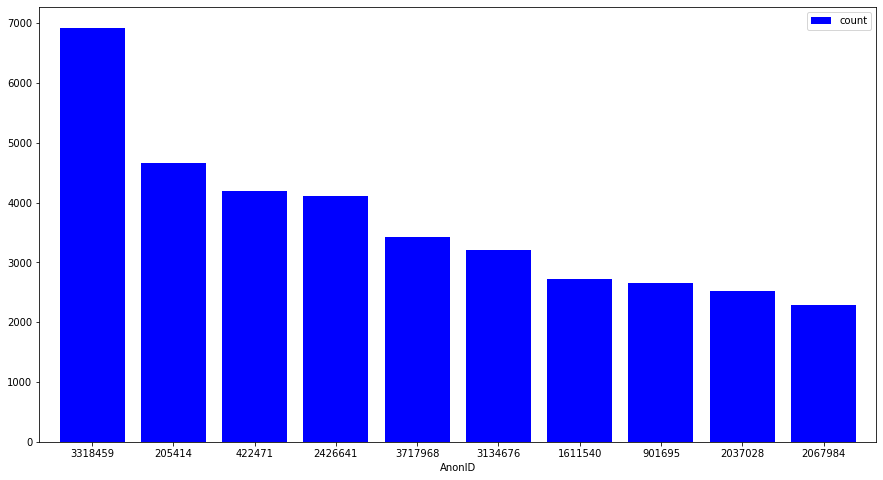

In [10]:
#Distribution of Queries by User, uneven distribution
query_by_users = ps.sqldf("SELECT AnonID, count(*) as count from raw_data Group by 1 order by count DESC LIMIT 50;", globals())
query_by_users
query_by_users_graph = query_by_users.set_index('AnonID').plot.bar(rot=0, figsize=(15,8), width=.8, color ='blue')
query_by_users_graph.set_ylabel("Query Count Per User",fontsize=15)


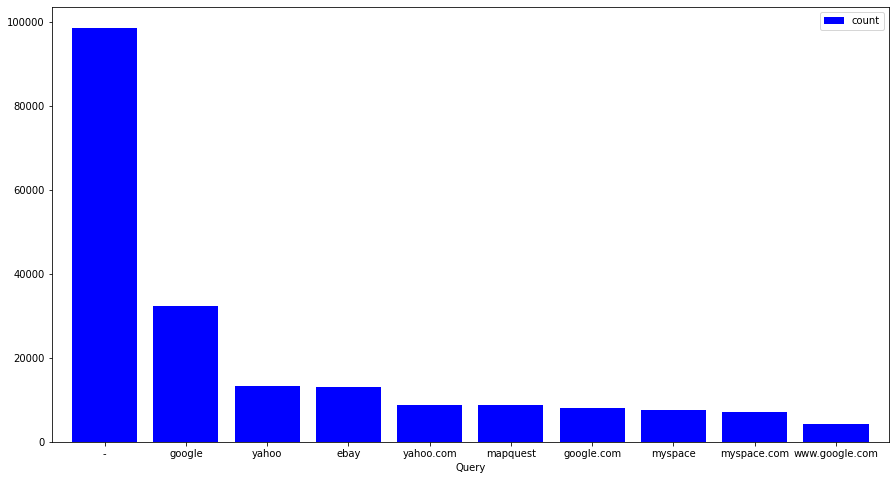

In [9]:
#There seems to be a lot of empty queries "-", could be a bug or a UX issue resulting in a blank query being executed
top_query = ps.sqldf("SELECT Query, count(*) as count from raw_data Group by 1 order by count DESC LIMIT 10;", globals())
top_query
top_query_picture = top_query.set_index('Query').plot.bar(rot=0, figsize=(15,8), width=.8, color ='blue')



In [20]:
null_query = ps.sqldf("SELECT query, count(*) as queries, sum(CASE WHEN clickurl is not null then 1 else 0 end) as clicks from raw_data where query = '-' Group by 1;", globals())

null_query['% of Total'] = (null_query['clicks'] / 
                  null_query['queries']) * 100
null_query
#31% of "-" queries led to clicks...odd

,Query,queries,clicks,% of Total
0,-,98554,31384,31.844471


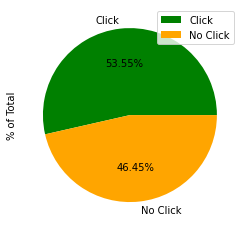

In [615]:
clicks_vs_no_clicks = ps.sqldf("SELECT CASE WHEN itemrank is null then 'No Click' else 'Click' end as CLICK_YN, COUNT(*) as Queries FROM raw_data  Group by 1 ORDER BY 2 DESC;", globals())
clicks_vs_no_clicks['% of Total'] = (clicks_vs_no_clicks['Queries'] / 
                  clicks_vs_no_clicks['Queries'].sum()) * 100
clicks_vs_no_clicks.head()
clicks_vs_no_clicks_picture = clicks_vs_no_clicks.set_index('CLICK_YN').plot.pie( y='% of Total', autopct='%1.2f%%', colors = ['green','orange'])

#46% of all queries do not get clicked...

In [82]:
query_led_to_clicks = ps.sqldf("SELECT Query, Count(ItemRank) as Clicks from raw_data Group by 1 Order by 2 ASC;", globals())
query_led_to_clicks.head(15)


,Query,Clicks
0,None,0
1,&,0
2,& anthony show radio,0
3,& dryers,0
4,& signs,0
5,& womble.com,0
6,&& & y&u,0
7,&dial,0
8,&hearts,0
9,&id 4519&area artist&artistid 4519&omniad 0&ta...,0


Text(0.5, 0, 'Number of words In Query')

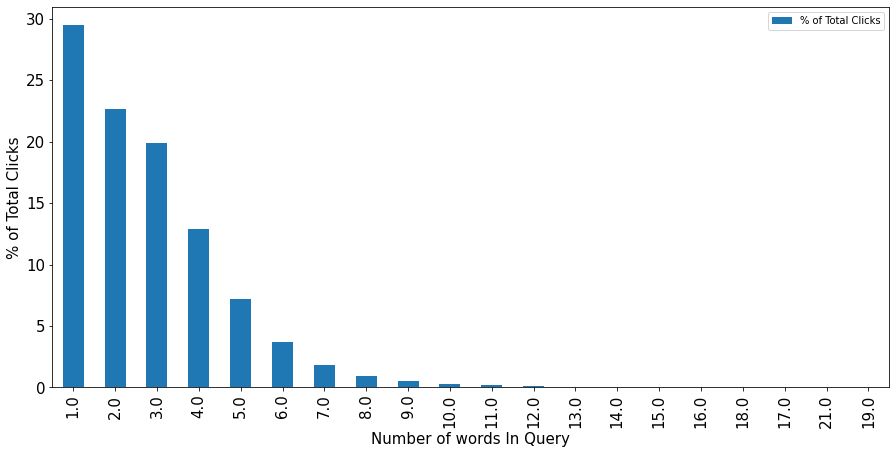

In [79]:
query_led_to_clicks['Clicks'].count()
df = query_led_to_clicks['Query'].str.count(' ').add(1).value_counts(sort=True)
df = pd.DataFrame({'Number of Words In Query':df.index, 'Clicks':df.values})
df['% of Total Clicks'] = (df['Clicks'] / 
                  df['Clicks'].sum()) * 100
word_chart = df.head(20).plot.bar(x='Number of Words In Query',y='% of Total Clicks',figsize=(15,7),fontsize=15) 
word_chart.set_ylabel("% of Total Clicks",fontsize=15)
word_chart.set_xlabel("Number of words In Query",fontsize=15)


In [80]:
df

,Number of Words In Query,Clicks,% of Total Clicks
0,1.0,366951,29.485936
1,2.0,282265,22.681088
2,3.0,247023,19.849256
3,4.0,160193,12.872129
4,5.0,89553,7.195931
...,...,...,...
83,151.0,1,0.000080
84,107.0,1,0.000080
85,65.0,1,0.000080
86,101.0,1,0.000080


In [377]:
NoClickCount = pd.DataFrame(raw_data[raw_data["ItemRank"].isna()].groupby(by="Query")["AnonID"] \
                           .count().sort_values(ascending=False)).reset_index()
NoClickCount.columns = ['Query','Count of Users W No Clicks']
print("{} queries or {}% did not lead to any click".format(NoClickCount.shape[0],NoClickCount.shape[0]*100/len(raw_data)))
NoClickCount
#NoClickCount['Profanity'] = NoClickCount['Query'].apply(lambda x: check_profanity(x))
#NoClickCount['Count'].sum()

785978 queries or 21.74510154361343% did not lead to any click


,Query,Count of Users W No Clicks
0,-,67170
1,google,6595
2,ebay,6410
3,internet,3791
4,yahoo.com,3516
...,...,...
785973,rollerderby girl,1
785974,rollercoastertycoon2downloads,1
785975,rollercoastertycoon2,1
785976,rollercoastertycoon,1


In [378]:
NoClickCount.head(50)

,Query,Count of Users W No Clicks
0,-,67170
1,google,6595
2,ebay,6410
3,internet,3791
4,yahoo.com,3516
5,mapquest,3110
6,http,3101
7,google.com,2619
8,yahoo,2168
9,myspace.com,2137


In [102]:
#Most Popular ClickURLs

df2 = raw_data.groupby(by="ClickURL").size().reset_index().rename(columns={0:"Count"}).sort_values(by="Count",ascending=False)
df2["% of Total Queries"] = (df2["Count"]/df2["Count"].sum()) * 100
df2.head(20)


,ClickURL,Count,% of Total Queries
193120,http://www.google.com,36103,1.865197
380917,http://www.yahoo.com,16271,0.840612
262798,http://www.myspace.com,15977,0.825423
23820,http://en.wikipedia.org,12275,0.634166
89747,http://www.amazon.com,11030,0.569845
212876,http://www.imdb.com,9791,0.505835
245007,http://www.mapquest.com,9402,0.485738
163869,http://www.ebay.com,7613,0.393312
42926,http://mail.yahoo.com,4814,0.248707
103407,http://www.bankofamerica.com,4495,0.232226


In [100]:
df2["Count"].sum()

1935613

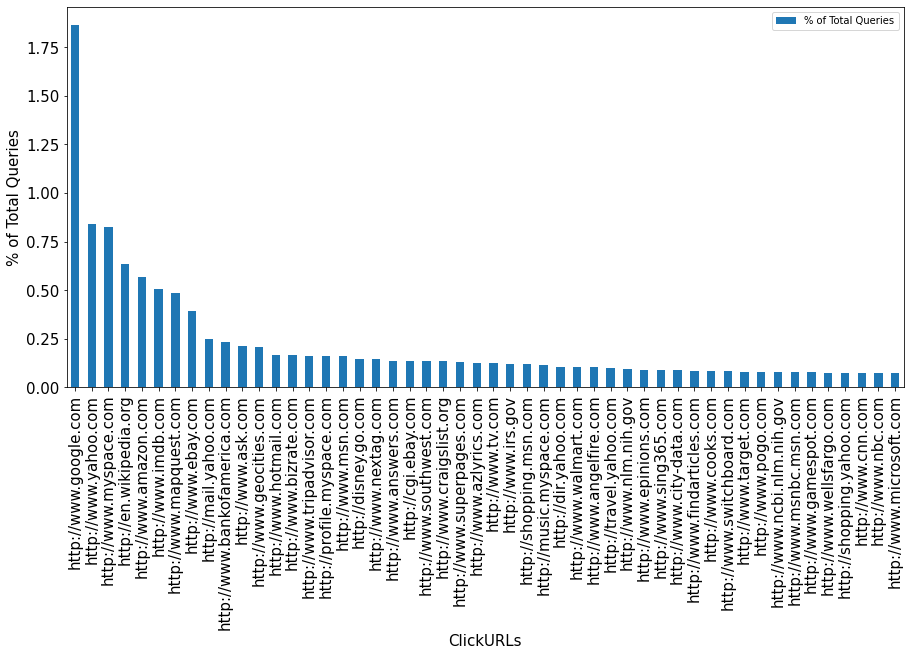

In [443]:
plot = df2.head(50).plot.bar(x='ClickURL',y='% of Total Queries',figsize=(15,7),fontsize=15) 
plot.set_xlabel("ClickURLs",fontsize=15) 
plot.set_ylabel("% of Total Queries",fontsize=15)
plt.show()

In [280]:
#> 50 ACTIVE DAYS
active_users = ps.sqldf("SELECT ANONID FROM (SELECT AnonID, Count(Distinct Date(QueryTime)) as number_of_days from raw_data group by 1 Having Count(Distinct Date(QueryTime)) > 50 order by number_of_days DESC) ;",globals())
unclicked_queries_by_active_users = ps.sqldf("SELECT distinct query from raw_data where itemrank is null and anonid in (Select anonid from active_users) and query is not null;",globals())
unclicked_queries_by_active_users


,Query
0,marblehead massachusetts library
1,out of business
2,out of business by dennis fieriy
3,victor santoro's samples
4,stories or samples of revenge
...,...
164705,oxazepan information
164706,metionina inforation
164707,oxido de magnesio inforation
164708,bodybuilding munder


In [ ]:
def check_profanity(data):
        prof.load_censor_words
        return prof.contains_profanity(data)

In [281]:
unclicked_queries_by_active_users['Profanity'] = unclicked_queries_by_active_users['Query'].apply(lambda x: check_profanity(x))
unclicked_queries_by_active_users

,Query,Profanity
0,marblehead massachusetts library,False
1,out of business,False
2,out of business by dennis fieriy,False
3,victor santoro's samples,False
4,stories or samples of revenge,False
...,...,...
164705,oxazepan information,False
164706,metionina inforation,False
164707,oxido de magnesio inforation,False
164708,bodybuilding munder,False


In [364]:
unclicked_queries_by_active_users['Spelling'] = unclicked_queries_by_active_users['Query'].apply(lambda x: spell_chkr(x))
unclicked_queries_by_active_users




,Query,Profanity,Spelling
0,marblehead massachusetts library,False,True
1,out of business,False,False
2,out of business by dennis fieriy,False,True
3,victor santoro's samples,False,True
4,stories or samples of revenge,False,False
...,...,...,...
164705,oxazepan information,False,True
164706,metionina inforation,False,True
164707,oxido de magnesio inforation,False,True
164708,bodybuilding munder,False,True


In [388]:
unclicked_queries_by_spelling['Spelling_YN'] = unclicked_queries_by_spelling['Spelling'].replace({0: 'Correctly Spelled', 1: 'Incorrectly Spelled'})

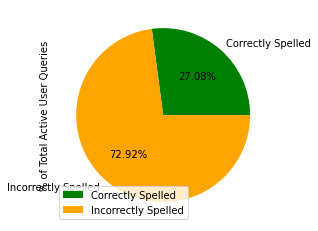

In [390]:
unclicked_queries_by_spelling['% of Total Active User Queries'] = (unclicked_queries_by_spelling['queries'] / 
                  unclicked_queries_by_spelling['queries'].sum()) * 100
unclicked_queries_by_spelling
unclicked_queries_by_spelling_chart = unclicked_queries_by_spelling.set_index('Spelling_YN').plot.pie( y='% of Total Active User Queries', autopct='%1.2f%%', colors = ['green','orange'])


In [336]:
def spell_chkr(data):
    chkr = SpellChecker("en_US")
    chkr.set_text(data)
    for err in chkr:
        return True
        break
    else:
        return False

    #unclicked_queries_spelling.insert([0,'Spelling',[data]])

In [283]:
unclicked_queries_by_active_users_profanity = ps.sqldf("SELECT profanity, count(*) as queries from unclicked_queries_by_active_users group by 1;",globals())
unclicked_queries_by_active_users_profanity

,Profanity,queries
0,0,161010
1,1,3700


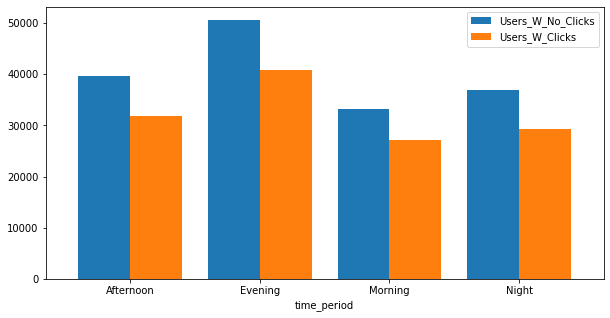

In [506]:
#unclicked_queries = raw_data[raw_data.ItemRank.isnull()]
#unclicked_queries = ps.sqldf("SELECT distinct query from raw_data where itemrank is null;",globals())
#unclicked_queries
unclicked_queries_report = ps.sqldf("SELECT CASE WHEN CAST(strftime('%H', QueryTime) as INT) BETWEEN 7 AND 11 THEN 'Morning' WHEN CAST(strftime('%H', QueryTime) as INT) BETWEEN 12 AND 15 THEN 'Afternoon' WHEN CAST(strftime('%H', QueryTime) as INT) BETWEEN 16 AND 21 THEN 'Evening' ELSE 'Night'END as time_period, count(distinct CASE WHEN itemrank is null then anonid end) as Users_W_No_Clicks, count(distinct CASE WHEN itemrank is not null then anonid end) as Users_W_Clicks from  raw_data group by 1;", globals())
unclicked_queries_report_chart = unclicked_queries_report.set_index('time_period').plot.bar(rot=0, figsize=(10,5), width=.8)
#no distribution change in users who observed clicks and didn't observe clicks across time periods


In [508]:
unclicked_queries_spelling = unclicked_queries.reset_index(drop=True)
unclicked_queries_spelling = unclicked_queries_spelling[pd.notnull(unclicked_queries_spelling.Query)]
unclicked_queries_spelling.reset_index(inplace = True) 
#unclicked_queries_spelling['Query'][6890]

'canary casino'

In [611]:
chkr = SpellChecker("en_US")
length = len(NoClickCount.head(500))
counter = 0
err.word = []
data = pd.Series([]) 
while len(NoClickCount.head(500)) > counter:
    chkr.set_text(NoClickCount.head(500)['Query'][counter])
    #print(unclicked_queries_spelling['Query'][counter])
    for err in chkr:
        if len(err.word) > 1:
            print(err.word)
            data[counter] = "True"  
            #print(counter)
            #err.word = []
            break;
        else:
            data[counter] = "False"
            break;
      
    counter = counter+1

print(data)
#unclicked_queries_spelling.insert([0,'Spelling',[data]])


<ipython-input-611-6efc2b10aed5>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data = pd.Series([])


rollercoastertycoon
rollercoastertycoon
rollercoastertycoon
rollerderby
rollerdome
rollergirls
rollerskate
rollercoaster
rollerskates
rollex
rollex
rolley
rolley's
rolleyes
rollie
rollin
rollex
rollercoaster
rollercoaster
ny
ontario
pasco
rollercoaster
philadelphia
citzens
michel
rollingstone
rollingstonemagazine
rollingstones
rollingstonlogo
rollingstonre
rollingthunder
rollins
rollins
rollling
rollling
rollmaster
rollmaster
rollngrow
rollof
rollof
rollins
rollingroadsbaptistchurch
orlando
orlando
elemetary
albumn
london
cystoon
coster
rolex
rolex
rolex
rolex
rolex
rolex
rolex
rolex
rolex
rolexkampfschwimmer
rolez
rolie
roling
rolinthunder
rolita
rolex
rolex
rolex
rolex
roleez
roleo
roleo
roleo
roleplay
roleplaying
roleplays
rolet
roleum
rolex
rolex
rolex
rolex
rolloff
rolla
rolla
rolla
rolla
rollack
rolland
rollandia
rollei
arizonia
mexico
boay
chicago
ny
aol
vip
vip
clublike
convestions
rolloff
monday
romanian
romanian
romanian
romanian
romanianambassy
romanic
romanina
romanian
roma

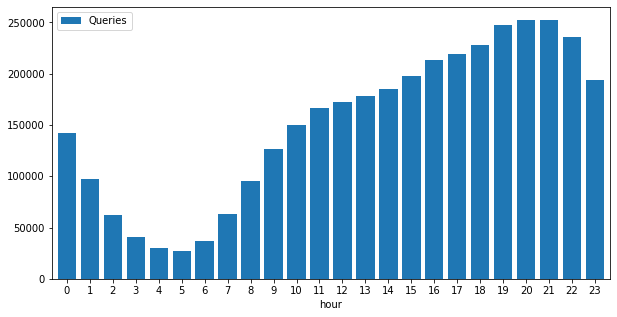

In [618]:
active_hours = ps.sqldf("SELECT CAST(strftime('%H', QueryTime) as INT) as hour, COUNT(*) as Queries FROM raw_data  Group by 1 ORDER BY 1 ASC;", globals())
active_hours_chart = active_hours.set_index('hour').plot.bar(rot=0, figsize=(10,5), width=.8)





          Frequency
Word               
-             26800
http           8389
pictures       5094
free           5063
com            4372
.com           3996
new            3798
www            3743
google         3268
ebay           2755
www.           2633
county         2622
lyrics         2521
american       2434
school         2424
home           2133
aol            2039
sex            2020
games          2018
florida        2013
\b(?:i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|bo

,Query,QueryTime,ItemRank
0,family guy,2006-03-01 16:01:20,NaN
1,also sprach zarathustra,2006-03-02 14:48:55,NaN
10,car sponsor decals,2006-03-03 23:28:59,NaN
11,car brand name decals,2006-03-03 23:29:35,NaN
12,brand name decals,2006-03-03 23:29:58,NaN
19,chicago radio annoucer whip,2006-03-04 22:16:07,NaN
20,chicago radio whip,2006-03-04 22:16:27,NaN
30,howard stern lawsuit,2006-03-08 00:14:55,NaN
32,opec,2006-03-09 09:19:29,NaN
40,wto history,2006-03-13 18:48:27,NaN


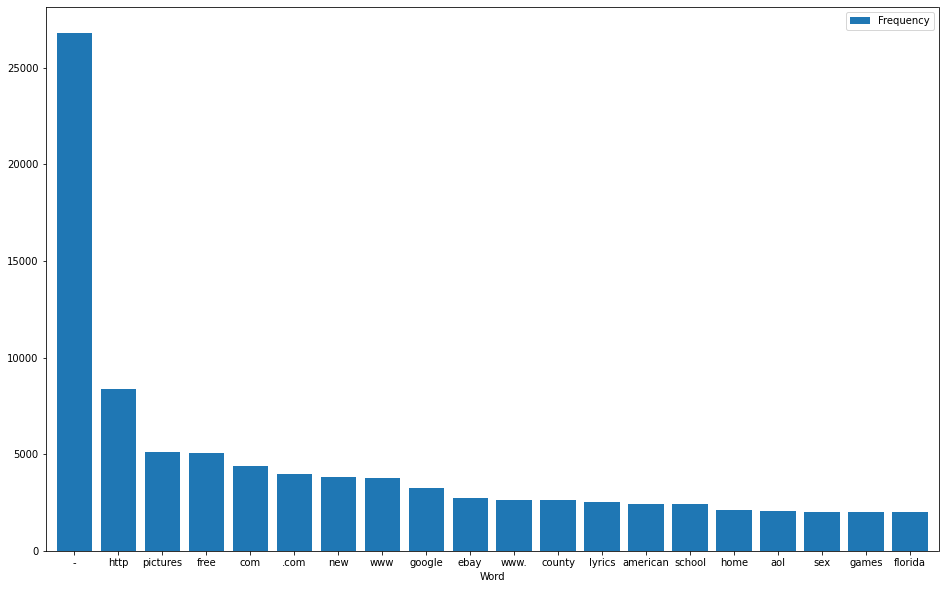

In [527]:
top_N = 20

df = pd.read_csv("/Users/ksingh/Downloads/user_data.txt",  sep='\t',
                 usecols=['Query', 'QueryTime', 'ItemRank'])

df = df[(df['ItemRank'].isnull())]

key_words_by_time = ps.sqldf("SELECT Query FROM df where (CASE WHEN CAST(strftime('%H', QueryTime) as INT)  BETWEEN 16 AND 21 THEN TRUE ELSE FALSE END) = TRUE;", globals())



stopwords = nltk.corpus.stopwords.words('english')
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (key_words_by_time.Query
           .str.lower()
           .replace('com|www|http|org', '')  
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

# plot
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

print(RE_stopwords)
df.head(20)


In [635]:

time_frame_df = ps.sqldf("SELECT CASE WHEN CAST(strftime('%H', QueryTime) as INT) BETWEEN 7 AND 11 THEN 'Morning' WHEN CAST(strftime('%H', QueryTime) as INT) BETWEEN 12 AND 16 THEN 'Afternoon' WHEN CAST(strftime('%H', QueryTime) as INT) BETWEEN 17 AND 21 THEN 'Evening' ELSE 'Night'END as timeframe, COUNT(*) as Queries FROM raw_data  Group by 1 ORDER BY 2 DESC;", globals())


In [636]:
time_frame_df['% Of Total Queries'] = (time_frame_df['Queries'] / 
                  time_frame_df['Queries'].sum()) * 100

time_frame_df

,timeframe,Queries,% Of Total Queries
0,Evening,1199304,33.180302
1,Afternoon,945877,26.168915
2,Night,867790,24.008537
3,Morning,601535,16.642247


Text(0, 0.5, '% of Total Queries')

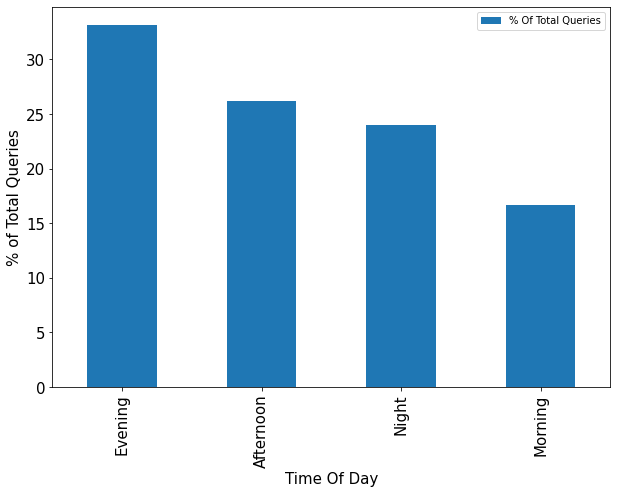

In [637]:
time_frame_chart = time_frame_df.plot.bar(x='timeframe',y='% Of Total Queries',figsize=(10,7),fontsize=15) 
time_frame_chart.set_xlabel("Time Of Day",fontsize=15) 
time_frame_chart.set_ylabel("% of Total Queries",fontsize=15)

In [58]:
df2['Queries'] = (df2['Queries'] / 
                  df2['Queries'].sum()) * 100

In [619]:
df2.head()

,ClickURL,Count,% of Total Queries
193120,http://www.google.com,36103,1.00
380917,http://www.yahoo.com,16271,0.45
262798,http://www.myspace.com,15977,0.44
23820,http://en.wikipedia.org,12275,0.34
89747,http://www.amazon.com,11030,0.31


In [406]:
next_page_requests = ps.sqldf("SELECT AnonID, Query, Count(*) as Count FROM raw_data where itemrank is not null and itemrank > 10 GROUP BY 1,2 HAVING Count > 1;", globals())
next_page_requests.head(10)

,AnonID,Query,Count
0,507,craigslist,2
1,507,ebay electronics,5
2,507,ghost hunting equipment,14
3,1020,slot machine tips,2
4,2708,anonymous sms text messenger,5
5,2708,black and white photos of motorcycles,3
6,2708,daytona bike week photos 2006,4
7,2708,derry new hampshire,2
8,2708,encyclopedia of revenge,4
9,2708,evil things to do to someone,2


In [407]:
#Percent of Uniques that click on next page
n = next_page_requests.AnonID.nunique()
n = n/len(raw_data.AnonID.value_counts())
n

0.15474242424242424

In [419]:
no_relevant_results = ps.sqldf("SELECT Query, Itemrank, count(*) number_of_queries from raw_data where itemrank is not null and itemrank > 20 Group by 1 Order by itemrank DESC;", globals())
no_relevant_results.head(15)

,Query,ItemRank,number_of_queries
0,bang my husband,500.0,2
1,twistys,431.0,1
2,mail order adult sex toy cataloges,416.0,7
3,animal raped children,394.0,1
4,raped children,385.0,1
5,golden retrievers,382.0,1
6,bottoms up,381.0,1
7,the eye center,378.0,2
8,fishing report,371.0,5
9,vulgar thumb,370.0,2


In [421]:
no_relevant_results['Profanity'] = no_relevant_results['Query'].apply(lambda x: check_profanity(x))
no_relevant_results

,Query,ItemRank,number_of_queries,Profanity
0,bang my husband,500.0,2,False
1,twistys,431.0,1,False
2,mail order adult sex toy cataloges,416.0,7,True
3,animal raped children,394.0,1,True
4,raped children,385.0,1,True
...,...,...,...,...
32751,100 free virgins and animal sex free samples,21.0,3,True
32752,.imgboard.cgi,21.0,1,False
32753,'pet strollers,21.0,19,False
32754,'byram dickes',21.0,5,False


In [425]:
no_relevant_results['Spelling'] = no_relevant_results['Query'].apply(lambda x: spell_chkr(x))


In [429]:
no_relevant_results_breakout['Profanity'] = no_relevant_results_breakout['Profanity'].replace({0: 'Does Not Contain Profanity', 1: 'Contains Profanity'})
no_relevant_results_breakout['Spelling'] = no_relevant_results_breakout['Spelling'].replace({0: 'Correct Spelling', 1: 'Incorrect Spelling'})

In [434]:
no_relevant_results_breakout = ps.sqldf("SELECT Spelling, Profanity, count(*) as Queries from no_relevant_results group by 1,2;", globals())

no_relevant_results_breakout['Profanity'] = no_relevant_results_breakout['Profanity'].replace({0: 'Does Not Contain Profanity', 1: 'Contains Profanity'})
no_relevant_results_breakout['Spelling'] = no_relevant_results_breakout['Spelling'].replace({0: 'Correct Spelling', 1: 'Incorrect Spelling'})

no_relevant_results_breakout['% of Total'] = (no_relevant_results_breakout['Queries'] / 
                  no_relevant_results_breakout['Queries'].sum()) * 100
no_relevant_results_breakout

,Spelling,Profanity,Queries,% of Total
0,Correct Spelling,Does Not Contain Profanity,14047,42.883746
1,Correct Spelling,Contains Profanity,1467,4.478569
2,Incorrect Spelling,Does Not Contain Profanity,16530,50.464037
3,Incorrect Spelling,Contains Profanity,712,2.173648


In [435]:
no_relevant_results_breakout = ps.sqldf("SELECT Profanity, count(*) as Queries from no_relevant_results group by 1;", globals())
no_relevant_results_breakout['Profanity'] = no_relevant_results_breakout['Profanity'].replace({0: 'Does Not Contain Profanity', 1: 'Contains Profanity'})
no_relevant_results_breakout['% of Total'] = (no_relevant_results_breakout['Queries'] / 
                  no_relevant_results_breakout['Queries'].sum()) * 100
no_relevant_results_breakout

,Profanity,Queries,% of Total
0,Does Not Contain Profanity,30577,93.347784
1,Contains Profanity,2179,6.652216


In [392]:
query_by_rank = ps.sqldf("SELECT (CASE WHEN ItemRank >10 then '>10' else ItemRank END ) as Rank, SUM(CASE WHEN ClickURL is not null THEN 1 ELSE 0 END) as Clicks FROM raw_data Where  ItemRank >=1 GROUP BY 1 ORDER BY RANK ASC;", globals())
query_by_rank.head(12)

query_by_rank['% of Total'] = (query_by_rank['Clicks'] / 
                  query_by_rank['Clicks'].sum()) * 100
query_by_rank.head(12)

 


,Rank,Clicks,% of Total
0,1,820089,42.376889
1,2,229562,11.862278
2,3,163995,8.474200
3,4,116853,6.038206
4,5,94555,4.885990
5,6,77417,4.000409
6,7,65521,3.385701
7,8,57185,2.954951
8,9,53904,2.785410
9,10,57110,2.951075


Text(0, 0.5, '% of Total Clicks')

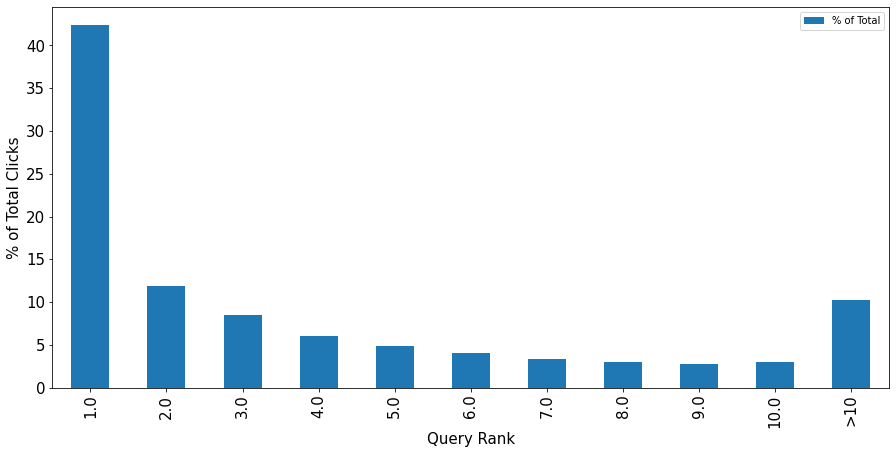

In [393]:
query_by_rank_chart = query_by_rank.head(50).plot.bar(x='Rank',y='% of Total',figsize=(15,7),fontsize=15) 
query_by_rank_chart.set_xlabel("Query Rank",fontsize=15) 
query_by_rank_chart.set_ylabel("% of Total Clicks",fontsize=15)


In [ ]:
#EXPERIMENTATION

distinct_users_with_null_first_click =  ps.sqldf("SELECT distinct AnonID as Daily_Anon_IDs from raw_data where initial_query_no_click is True;", globals())
distinct_users_with_null_first_click

pandas2= raw_data[~raw_data.AnonID.isin(distinct_users_with_null_first_click['Daily_Anon_IDs'])]
pandas2

#count all query attempts across all user sessions
raw_data['ATTEMPTS'] = raw_data.sort_values(['AnonID','QueryTime'], ascending=[True,True]) \
             .groupby(['AnonID']) \
             .cumcount() + 1
#Convert Querytime to Date
raw_data['QueryDate'] = pd.to_datetime(raw_data['QueryTime']).apply(lambda x: x.date())

#True when initial user query is null 
raw_data['initial_query_no_click'] = np.where(raw_data['ATTEMPTS'] == 1 & raw_data['ClickURL'].isnull(), True, False)


#SnowflakeTable
select *
from(

select anonid, Querytime, query, clickurl,   
  CASE WHEN CAST(HOUR(TO_TIMESTAMP(QueryTime)) as INT) BETWEEN 7 AND 11 THEN 'Morning' WHEN CAST(HOUR(TO_TIMESTAMP(QueryTime)) as INT) BETWEEN 12 AND 15 THEN 'Afternoon' WHEN CAST(HOUR(TO_TIMESTAMP(QueryTime)) as INT) BETWEEN 16 AND 21 THEN 'Evening' ELSE 'Night'END as time,     
  count(*) over (partition by anonid order by Querytime rows between unbounded preceding and 0 preceding) as attempts, case when attempts =1 and clickurl is null then 'initial_null' end as initial
  from  USER_SCRATCH.X_KSINGH_A.USER_SEARCH_DATA_X
where  DATE(Querytime) = '2006-04-30' 
order by anonid,Querytime asc 
)

where anonid in (

  select distinct anonid from (
select anonid, Querytime, query, clickurl,        count(*) over (partition by anonid order by Querytime rows between unbounded preceding and 0 preceding) as attempts, case when attempts =1 and clickurl is null then 'initial_null' end as initial
from  USER_SCRATCH.X_KSINGH_A.USER_SEARCH_DATA_X
where  DATE(Querytime) = '2006-04-30' 
order by anonid,Querytime asc) where initial = 'initial_null')
and  clickurl is not null
